In [1]:
from transformers import (
    AutoConfig,
    AutoModelForMultipleChoice,
)

/u/lucmon/lucmon/anaconda3/envs/mlopt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "roberta-base"

config = AutoConfig.from_pretrained(
        model_name,
        #cache_dir=model_args.cache_dir,
        revision="main",
        use_auth_token=None,
    )

model = AutoModelForMultipleChoice.from_pretrained(
        model_name,
        from_tf=bool(".ckpt" in model_name),
        config=config,
        #cache_dir=model_args.cache_dir,
        revision="main",
        use_auth_token=None,
    )

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'arch'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
from lora import add_adapters_dataset

model , output_layer_name, Lora_Config = add_adapters_dataset(model_name, model, 16, 16, lora_freeze_a=False)

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
/u/lucmon/lucmon/anaconda3/envs/mlopt/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
base_name = "base_model.model.roberta.encoder.layer.0.attention.self.value.base_layer.weight"
#base_name = "base_model.model.roberta.encoder.layer.0.attention.self.value.weight"
def base_to_lora_name(base_name):
    lora_A_name = base_name.replace("base_layer", "lora_A.default")
    lora_B_name = base_name.replace("base_layer", "lora_B.default")
    return lora_A_name, lora_B_name
lora_A_name, lora_B_name = base_to_lora_name(base_name)

#lora_A_name, lora_B_name = None, None
for name, param in model.named_parameters():
    if name == base_name:
        print("???")
        base_param = param.clone()
    if name == lora_A_name:
        print("A")
        lora_A_param = param
    if name == lora_B_name:
        print('B')
        lora_B_param = param
print(lora_A_param.shape, lora_B_param.shape)

???
A
B
torch.Size([16, 768]) torch.Size([768, 16])


In [7]:
lora_A_name

In [9]:
import torch
lora_B_param.data = torch.randn_like(lora_B_param)

scaling = 1
my_product = scaling * lora_B_param @ lora_A_param
merged_model = model.merge_and_unload()
merged_base_name = "roberta.encoder.layer.0.attention.self.value.weight"
for name, param in merged_model.named_parameters():
    if name == merged_base_name:
        real_update = param - base_param
        break

In [11]:
print(my_product)

tensor([[ 0.0560, -0.0255,  0.1228,  ...,  0.0728, -0.1704,  0.0258],
        [ 0.0490, -0.1293, -0.0183,  ..., -0.0340, -0.0298,  0.1013],
        [ 0.0850,  0.0555, -0.0552,  ...,  0.1703, -0.1314, -0.1007],
        ...,
        [-0.1876,  0.0186,  0.0640,  ..., -0.0252,  0.0345, -0.1034],
        [ 0.0117, -0.0402,  0.0104,  ..., -0.0239,  0.0612,  0.0206],
        [ 0.0506,  0.0426,  0.0024,  ...,  0.0611, -0.1517, -0.1562]],
       grad_fn=<MmBackward0>)


In [10]:
print(real_update)

tensor([[ 0.0560, -0.0255,  0.1228,  ...,  0.0728, -0.1704,  0.0258],
        [ 0.0490, -0.1293, -0.0183,  ..., -0.0340, -0.0298,  0.1013],
        [ 0.0850,  0.0555, -0.0552,  ...,  0.1703, -0.1314, -0.1007],
        ...,
        [-0.1876,  0.0186,  0.0640,  ..., -0.0252,  0.0345, -0.1034],
        [ 0.0117, -0.0402,  0.0104,  ..., -0.0239,  0.0612,  0.0206],
        [ 0.0506,  0.0426,  0.0024,  ...,  0.0611, -0.1517, -0.1562]])


In [5]:
for name, param in model.named_parameters():
    print(name)

base_model.model.roberta.embeddings.word_embeddings.weight
base_model.model.roberta.embeddings.position_embeddings.weight
base_model.model.roberta.embeddings.token_type_embeddings.weight
base_model.model.roberta.embeddings.LayerNorm.weight
base_model.model.roberta.embeddings.LayerNorm.bias
base_model.model.roberta.encoder.layer.0.attention.self.query.base_layer.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.bias
base_model.model.roberta.encoder.layer.0.attention.self.value.base_layer.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.base_layer.bias
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_mode

# ViT

In [12]:
model_name == "google/vit-base-patch16-224-in21k"        
from transformers import AutoModelForImageClassification
model = AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'arch'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
from lora import add_adapters_dataset

model , output_layer_name, Lora_Config = add_adapters_dataset(model_name, model, 16, 16, lora_freeze_a=False)

In [14]:
for name, param in model.named_parameters():
    print(name)

base_model.model.vit.embeddings.cls_token
base_model.model.vit.embeddings.position_embeddings
base_model.model.vit.embeddings.patch_embeddings.projection.weight
base_model.model.vit.embeddings.patch_embeddings.projection.bias
base_model.model.vit.encoder.layer.0.attention.attention.query.base_layer.weight
base_model.model.vit.encoder.layer.0.attention.attention.query.base_layer.bias
base_model.model.vit.encoder.layer.0.attention.attention.query.lora_A.default.weight
base_model.model.vit.encoder.layer.0.attention.attention.query.lora_B.default.weight
base_model.model.vit.encoder.layer.0.attention.attention.key.weight
base_model.model.vit.encoder.layer.0.attention.attention.key.bias
base_model.model.vit.encoder.layer.0.attention.attention.value.base_layer.weight
base_model.model.vit.encoder.layer.0.attention.attention.value.base_layer.bias
base_model.model.vit.encoder.layer.0.attention.attention.value.lora_A.default.weight
base_model.model.vit.encoder.layer.0.attention.attention.value.lo

In [15]:
base_name = "base_model.model.vit.encoder.layer.0.attention.attention.value.base_layer.weight"
#base_name = "base_model.model.roberta.encoder.layer.0.attention.self.value.weight"
def base_to_lora_name(base_name):
    lora_A_name = base_name.replace("base_layer", "lora_A.default")
    lora_B_name = base_name.replace("base_layer", "lora_B.default")
    return lora_A_name, lora_B_name
lora_A_name, lora_B_name = base_to_lora_name(base_name)

#lora_A_name, lora_B_name = None, None
for name, param in model.named_parameters():
    if name == base_name:
        print("???")
        base_param = param.clone()
    if name == lora_A_name:
        print("A")
        lora_A_param = param
    if name == lora_B_name:
        print('B')
        lora_B_param = param
print(lora_A_param.shape, lora_B_param.shape)

???
A
B
torch.Size([16, 768]) torch.Size([768, 16])


In [16]:
import torch
lora_B_param.data = torch.randn_like(lora_B_param)

scaling = 1
my_product = scaling * lora_B_param @ lora_A_param
merged_model = model.merge_and_unload()

In [17]:
for name, param in merged_model.named_parameters():
    print(name)

vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.encoder.layer.1.attention.attention.query

In [18]:
merged_base_name = "vit.encoder.layer.0.attention.attention.value.weight"
for name, param in merged_model.named_parameters():
    if name == merged_base_name:
        real_update = param - base_param
        break

In [19]:
print(real_update)

tensor([[ 0.0321,  0.0991, -0.1132,  ..., -0.1183,  0.1426, -0.1396],
        [ 0.0086, -0.0049,  0.0900,  ...,  0.1232, -0.0167, -0.0734],
        [-0.0950, -0.0079,  0.0176,  ...,  0.0036, -0.0152,  0.1182],
        ...,
        [ 0.0895, -0.1026,  0.0633,  ...,  0.0311, -0.0354,  0.0450],
        [ 0.1237, -0.0355, -0.0320,  ..., -0.0396,  0.0303,  0.0164],
        [ 0.1022, -0.1361,  0.0503,  ...,  0.1041, -0.0256,  0.0526]])


In [20]:
print(my_product)

tensor([[ 0.0321,  0.0991, -0.1132,  ..., -0.1183,  0.1426, -0.1396],
        [ 0.0086, -0.0049,  0.0900,  ...,  0.1232, -0.0167, -0.0734],
        [-0.0950, -0.0079,  0.0176,  ...,  0.0036, -0.0152,  0.1182],
        ...,
        [ 0.0895, -0.1026,  0.0633,  ...,  0.0311, -0.0354,  0.0450],
        [ 0.1237, -0.0355, -0.0320,  ..., -0.0396,  0.0303,  0.0164],
        [ 0.1022, -0.1361,  0.0503,  ...,  0.1041, -0.0256,  0.0526]],
       grad_fn=<MmBackward0>)


#GPT2

In [21]:
from transformers import AutoModelForSequenceClassification
model_name = "gpt2"
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=20,pad_token_id=50256)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'arch'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
from lora import add_adapters_dataset

model , output_layer_name, Lora_Config = add_adapters_dataset(model_name, model, 16, 16, lora_freeze_a=False)

/u/lucmon/lucmon/anaconda3/envs/mlopt/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [26]:
for name, param in model.named_parameters():
    print(name, param.shape)

base_model.model.transformer.wte.weight torch.Size([50257, 768])
base_model.model.transformer.wpe.weight torch.Size([1024, 768])
base_model.model.transformer.h.0.ln_1.weight torch.Size([768])
base_model.model.transformer.h.0.ln_1.bias torch.Size([768])
base_model.model.transformer.h.0.attn.c_attn.base_layer.weight torch.Size([768, 2304])
base_model.model.transformer.h.0.attn.c_attn.base_layer.bias torch.Size([2304])
base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight torch.Size([16, 768])
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight torch.Size([2304, 16])
base_model.model.transformer.h.0.attn.c_proj.base_layer.weight torch.Size([768, 768])
base_model.model.transformer.h.0.attn.c_proj.base_layer.bias torch.Size([768])
base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight torch.Size([16, 768])
base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight torch.Size([768, 16])
base_model.model.transformer.h.0.ln_2.weight torch.Size([7

In [28]:
base_name = "base_model.model.transformer.h.0.attn.c_attn.base_layer.weight"
#base_name = "base_model.model.roberta.encoder.layer.0.attention.self.value.weight"
def base_to_lora_name(base_name):
    lora_A_name = base_name.replace("base_layer", "lora_A.default")
    lora_B_name = base_name.replace("base_layer", "lora_B.default")
    return lora_A_name, lora_B_name
lora_A_name, lora_B_name = base_to_lora_name(base_name)

#lora_A_name, lora_B_name = None, None
for name, param in model.named_parameters():
    if name == base_name:
        print("???")
        base_param = param.clone()
    if name == lora_A_name:
        print("A")
        lora_A_param = param
    if name == lora_B_name:
        print('B')
        lora_B_param = param
print(lora_A_param.shape, lora_B_param.shape)

???
A
B
torch.Size([16, 768]) torch.Size([2304, 16])


In [29]:
import torch
lora_B_param.data = torch.randn_like(lora_B_param)

scaling = 1
my_product = scaling * lora_B_param @ lora_A_param
merged_model = model.merge_and_unload()

In [30]:
for name, param in merged_model.named_parameters():
    print(name)

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

In [31]:
merged_base_name = "transformer.h.0.attn.c_attn.weight"
for name, param in merged_model.named_parameters():
    if name == merged_base_name:
        real_update = param - base_param
        break

In [34]:
print(real_update)
print(real_update.shape)

tensor([[-0.0546, -0.0664,  0.0471,  ...,  0.1405,  0.0787,  0.0821],
        [ 0.1177, -0.0407,  0.0580,  ...,  0.0716, -0.0565, -0.0031],
        [-0.0689, -0.0574, -0.0427,  ...,  0.0564, -0.0220,  0.0140],
        ...,
        [ 0.1406,  0.1481,  0.0080,  ...,  0.0284,  0.0265,  0.0121],
        [ 0.0258,  0.0373, -0.0037,  ...,  0.0410,  0.0567, -0.0127],
        [-0.1159, -0.0073,  0.0870,  ...,  0.0939,  0.0538,  0.0147]])
torch.Size([768, 2304])


In [35]:
print(my_product)
print(my_product.shape)

tensor([[-0.0546,  0.1177, -0.0689,  ...,  0.1406,  0.0258, -0.1159],
        [-0.0664, -0.0407, -0.0574,  ...,  0.1481,  0.0373, -0.0073],
        [ 0.0471,  0.0580, -0.0427,  ...,  0.0080, -0.0037,  0.0870],
        ...,
        [ 0.1405,  0.0716,  0.0564,  ...,  0.0284,  0.0410,  0.0939],
        [ 0.0787, -0.0565, -0.0220,  ...,  0.0265,  0.0567,  0.0538],
        [ 0.0821, -0.0031,  0.0140,  ...,  0.0121, -0.0127,  0.0147]],
       grad_fn=<MmBackward0>)
torch.Size([2304, 768])


In [ ]:
## minimal example

In [1]:
from scipy.sparse.linalg import LinearOperator, eigsh
from torch.nn.utils import parameters_to_vector
from torch.utils.data import Dataset, DataLoader
DEFAULT_PHYS_BS = 1000
import torch
from torch import Tensor
import torch.nn as nn

def iterate_dataset(dataset: Dataset, batch_size: int):
    """Iterate through a dataset, yielding batches of data."""
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    #print(device)
    for (batch_X, batch_y) in loader:
        yield batch_X.to(device), batch_y.to(device)

def compute_hvp(network: nn.Module, loss_fn: nn.Module,
                dataset: Dataset, vector: Tensor, physical_batch_size: int = DEFAULT_PHYS_BS):
    """Compute a Hessian-vector product."""
    p = len(parameters_to_vector(network.parameters()))
    n = len(dataset)
    hvp = torch.zeros(p, dtype=torch.float, device=device)
    vector = vector.to(device)
    for (X, y) in iterate_dataset(dataset, physical_batch_size):
        #loss = loss_fn(network(X), y) / n
        loss = loss_fn(network(X.to(device)), torch.nn.functional.one_hot(y.to(device), num_classes=10).float()) / n
        #print(loss)
        #for param in network.parameters():
        #    print(param.data)
        """
        param_list = []
        for param in network.parameters():
            param_list.append(param)
            assert param.requires_grad
        beta = torch.square(param_list[0]) - torch.square(param_list[1])
        loss = 0.25*torch.mean((X@beta-y)**2)
        """
        #loss = loss_fn(network(X), y) / n
        #loss = 0.25 * torch.mean((network(X).squeeze()-y.squeeze())**2)
        grads = torch.autograd.grad(loss, inputs=network.parameters(), create_graph=True)
        dot = parameters_to_vector(grads).mul(vector).sum()
        grads = [g.contiguous() for g in torch.autograd.grad(dot, network.parameters(), retain_graph=True)]
        hvp += parameters_to_vector(grads)
    return hvp


def lanczos(matrix_vector, dim: int, neigs: int, which="SA"):
    """ Invoke the Lanczos algorithm to compute the leading eigenvalues and eigenvectors of a matrix / linear operator
    (which we can access via matrix-vector products). """

    def mv(vec: np.ndarray):
        gpu_vec = torch.tensor(vec, dtype=torch.float).to(device)
        return matrix_vector(gpu_vec)

    operator = LinearOperator((dim, dim), matvec=mv)
    l_evals, l_evecs = eigsh(operator, neigs, which=which)
    #s_evals, s_evecs= eigsh(operator, neigs, which='SM')
    return torch.from_numpy(np.ascontiguousarray(l_evals[::-1]).copy()).float(), \
           torch.from_numpy(np.ascontiguousarray(np.flip(l_evecs, -1)).copy()).float()

def get_hessian_eigenvalues(network: nn.Module, loss_fn: nn.Module, dataset: Dataset,
                            neigs=6, physical_batch_size=1000):
    #vector_test = torch.ones(200)
    #print(compute_hvp(network, loss_fn, dataset, vector_test, physical_batch_size=physical_batch_size))
    #sys.exit()
    """ Compute the leading Hessian eigenvalues. """
    hvp_delta = lambda delta: compute_hvp(network, loss_fn, dataset,
                                          delta, physical_batch_size=physical_batch_size).detach().cpu()
    nparams = len(parameters_to_vector((network.parameters())))
    l_evals, l_evecs = lanczos(hvp_delta, nparams, neigs=neigs)
    return l_evals, l_evecs

def get_grad_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# ----------------------
# LoRA wrapper for Linear
# ----------------------
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=1.0):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        
        # Low-rank adapters
        self.r = r
        if r > 0:
            self.A = nn.Linear(in_features, r, bias=False)
            self.B = nn.Linear(r, out_features, bias=False)
            # Scale factor
            self.scaling = alpha / r
        else:
            self.A, self.B, self.scaling = None, None, None

    def forward(self, x):
        result = self.linear(x)
        if self.r > 0:
            lora_update = self.B(self.A(x)) * self.scaling
            result = result + lora_update
        return result

# ----------------------
# Two-layer MLP with LoRA
# ----------------------
class LoRAMLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256, num_classes=10, r=4):
        super().__init__()
        #self.fc1 = LoRALinear(input_dim, hidden_dim, r=r)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = LoRALinear(hidden_dim, num_classes, r=r)
        self.hidden_dim = hidden_dim

    def forward(self, x, layer_norm=False):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if layer_norm:
            x = F.layer_norm(x, (self.hidden_dim, ))
        x = self.fc2(x)
        return x

# ----------------------
# Training Loop
# ----------------------
loss_fn = torch.nn.MSELoss() #torch.nn.CrossEntropyLoss()
def train(model, device, train_loader, optimizer, epoch, layer_norm, analysis_dataset):
    model.train()
    losses, eigs, grad_norms = [], [], []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, layer_norm)
        target = F.one_hot(target, num_classes=10).float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            losses.append(loss.item())
            l_evals, _ = get_hessian_eigenvalues(model, loss_fn, analysis_dataset, neigs=6, physical_batch_size=1000)
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}\tEigs: {l_evals[0].item():.6f}")
            eigs.append(l_evals[0])
            grad_norm = get_grad_norm(model)
            grad_norms.append(grad_norm)

    return losses, eigs, grad_norms

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            onehot_target = F.one_hot(target, num_classes=10).float()
            output = model(data)
            test_loss += loss_fn(output, onehot_target).item()
            pred = torch.abs(output-1).argmin(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

analysis_dataset = torch.utils.data.Subset(train_dataset, torch.arange(100))
train_loader = DataLoader(analysis_dataset, batch_size=100, shuffle=True)
"""
# Model + Optimizer
model = LoRAMLP(r=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
loss_norm = []
for epoch in range(1, 6):
    losses = train(model, device, train_loader, optimizer, epoch, layer_norm=True)
    test(model, device, test_loader)
    loss_norm.extend(losses)
"""

NameError: name 'transforms' is not defined

In [5]:
model = LoRAMLP(r=8).to(device)

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

fc1.weight torch.Size([256, 784]) True
fc1.bias torch.Size([256]) True
fc2.linear.weight torch.Size([10, 256]) True
fc2.A.weight torch.Size([8, 256]) True
fc2.B.weight torch.Size([10, 8]) True


In [4]:
loss_norm_run = []
eigs_norm_run = []
grads_norm_run = []
for runs in range(1):
    model = LoRAMLP(r=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    loss_norm = []
    eigs_norm = []
    grads_norm = []
    for epoch in range(1, 50):
        losses, eigs, grads = train(model, device, train_loader, optimizer, epoch, layer_norm=True, analysis_dataset=analysis_dataset)
        test(model, device, test_loader)
        loss_norm.extend(losses)
        eigs_norm.extend(eigs)
        grads_norm.extend(grads)
    loss_norm_run.append(loss_norm)
    eigs_norm_run.append(eigs_norm)
    grads_norm_run.append(grads_norm)

Train Epoch: 1 [0/100]	Loss: 0.346738	Eigs: -0.005118

Test set: Average loss: 0.0001, Accuracy: 1087/10000 (10.87%)

Train Epoch: 2 [0/100]	Loss: 0.614055	Eigs: -0.003866

Test set: Average loss: 0.0001, Accuracy: 2285/10000 (22.85%)

Train Epoch: 3 [0/100]	Loss: 0.157624	Eigs: -0.003313

Test set: Average loss: 0.0001, Accuracy: 3468/10000 (34.68%)

Train Epoch: 4 [0/100]	Loss: 0.082964	Eigs: -0.003717

Test set: Average loss: 0.0001, Accuracy: 3700/10000 (37.00%)

Train Epoch: 5 [0/100]	Loss: 0.148492	Eigs: -0.003902

Test set: Average loss: 0.0001, Accuracy: 3722/10000 (37.22%)

Train Epoch: 6 [0/100]	Loss: 0.142685	Eigs: -0.003773

Test set: Average loss: 0.0001, Accuracy: 3944/10000 (39.44%)



: 

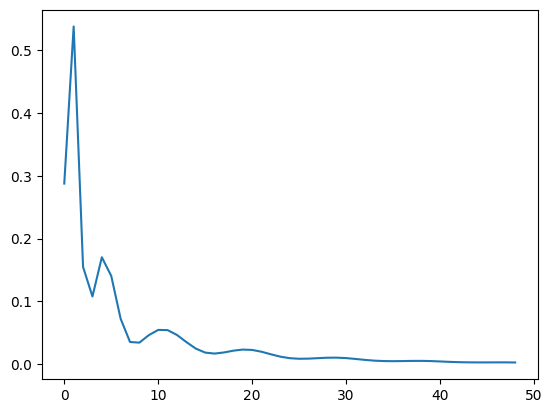

In [11]:
plt.plot(loss_norm_run[0])

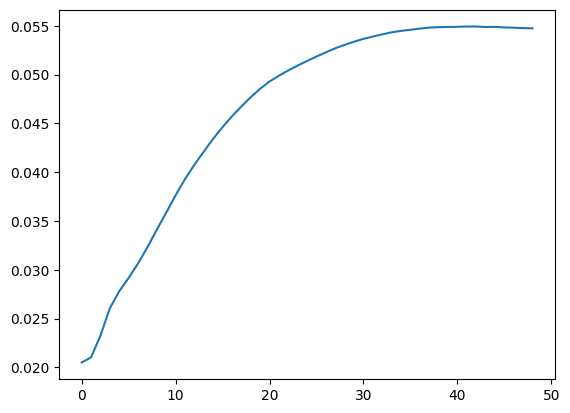

In [12]:
plt.plot(eigs_norm_run[0])

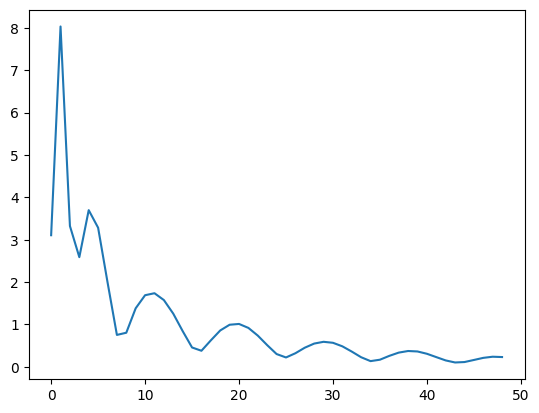

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.plot(grads_norm_run[0])

In [4]:
loss_no_norm_run = []
for runs in range(10):
    model = LoRAMLP(r=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Train
    loss_no_norm = []
    for epoch in range(1, 6):
        losses = train(model, device, train_loader, optimizer, epoch, layer_norm=False)
        test(model, device, test_loader)
        loss_no_norm.extend(losses)
    loss_no_norm_run.append(loss_no_norm)

Train Epoch: 1 [0/60000]	Loss: 2.311347
Train Epoch: 1 [6400/60000]	Loss: 0.274945
Train Epoch: 1 [12800/60000]	Loss: 0.301690
Train Epoch: 1 [19200/60000]	Loss: 0.426659
Train Epoch: 1 [25600/60000]	Loss: 0.321909
Train Epoch: 1 [32000/60000]	Loss: 0.101809
Train Epoch: 1 [38400/60000]	Loss: 0.466030
Train Epoch: 1 [44800/60000]	Loss: 0.152469
Train Epoch: 1 [51200/60000]	Loss: 0.223822
Train Epoch: 1 [57600/60000]	Loss: 0.221972

Test set: Average loss: 0.1432, Accuracy: 9585/10000 (95.85%)

Train Epoch: 2 [0/60000]	Loss: 0.101318
Train Epoch: 2 [6400/60000]	Loss: 0.188628
Train Epoch: 2 [12800/60000]	Loss: 0.291055
Train Epoch: 2 [19200/60000]	Loss: 0.082511
Train Epoch: 2 [25600/60000]	Loss: 0.125436
Train Epoch: 2 [32000/60000]	Loss: 0.128195
Train Epoch: 2 [38400/60000]	Loss: 0.045317
Train Epoch: 2 [44800/60000]	Loss: 0.101418
Train Epoch: 2 [51200/60000]	Loss: 0.103786
Train Epoch: 2 [57600/60000]	Loss: 0.067739

Test set: Average loss: 0.1026, Accuracy: 9692/10000 (96.92%)

Tr

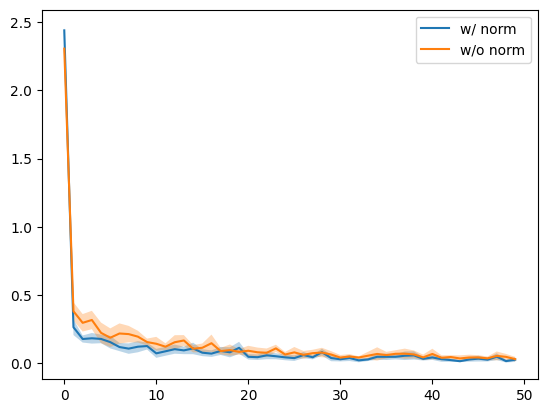

: 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


loss_num_run = np.array(loss_num_run)
norm_run_mean = loss_num_run.mean(axis=0)
norm_run_sem = stats.sem(loss_num_run, axis=0) * 1.96

loss_no_norm_run = np.array(loss_no_norm_run)
no_norm_run_mean = loss_no_norm_run.mean(axis=0)
no_norm_run_sem = stats.sem(loss_no_norm_run, axis=0) * 1.96

length = loss_num_run.shape[1]

plt.plot(np.arange(length), norm_run_mean, label="Mean across runs")

plt.plot(np.arange(length), no_norm_run_mean, label="Mean across runs")
plt.fill_between(np.arange(length), norm_run_mean - norm_run_sem, norm_run_mean + norm_run_sem, alpha=0.3, label="95% CI")

plt.fill_between(np.arange(length), no_norm_run_mean - no_norm_run_sem, no_norm_run_mean + no_norm_run_sem, alpha=0.3, label="95% CI")

plt.legend(["w/ norm", "w/o norm"])